In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
from skimage.feature import hog
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm

import joblib
from sklearn import datasets, svm, metrics
from sklearn import metrics

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

#define paths and read data
style_file = './myntradataset/styles.csv'
image_folder =  './myntradataset/images/'
styles = pd.read_csv(Path(style_file),error_bad_lines=False)


#Load image to list all_images
all_images = []


def load_image(ids,path=image_folder):
    img = cv.imread(image_folder+ids+'.jpg',cv.IMREAD_GRAYSCALE) #load at gray scale
    return img,ids

for ids in tqdm(list(styles.id)[:44441]):
    img,ids = load_image(str(ids))
    if img is not None:
        all_images.append([img,int(ids)])

def resize_image(img,ids):
    return cv.resize(img, (60, 80),interpolation =cv.INTER_LINEAR)
    
all_images_resized = [[resize_image(x,y),y] for x,y in all_images]


#Check distribution of the classes¶
df_labels = pd.DataFrame(all_images_resized,columns=['image','id'])

target = 'masterCategory'
categories = ['Apparel', 'Accessories', 'Footwear', 'Personal Care']
df_train = styles[styles[target].isin(categories)][['id',target]]

df_labels = pd.merge(df_labels,df_train,how='left',on=['id'])
df_labels = df_labels.fillna('Others')
df_labels['class'] = pd.factorize(df_labels[target])[0]

print("Data Shape: ", str(df_labels.shape))
print(df_labels[target].value_counts())

#mapper for targets and labels
mapper = df_labels[['class',target]].drop_duplicates()

#Feature Extraction using HOG
train_images = np.stack(df_labels.image.values,axis=0)
hog_images = []
hog_features = []
for image in tqdm(train_images):
    blur = cv.GaussianBlur(image,(5,5),0)
    fd,hog_image = hog(blur, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,transform_sqrt=True, block_norm="L2")
    hog_images.append(hog_image)
    hog_features.append(fd)

hog_features = np.array(hog_features)


    
train_features, test_features ,train_label, test_label = train_test_split(
    hog_features,df_labels['class'],test_size=0.2,stratify=df_labels['class'])

print('Training data {}'.format(train_features.shape))
print('Test data and target sizes: {}'.format(test_features.shape))

x

#k-NN algorithm 
test_accuracy = []


model = KNeighborsClassifier(algorithm='auto',n_neighbors=1)
model.fit(train_features, train_label)

y_pred = model.predict(test_features)

print ("Print results for 20 test data points:")
print ("Predicted labels: ", y_pred[-20:])
print ("Ground truth    : ", test_label[-20:].values)

test_accuracy = model.score(test_features, test_label)
print(test_accuracy)

list_of_categories = categories +['Others']

print("Classification Report: \n Target: %s \n Labels: %s \n Classifier: %s:\n%s\n"
      % (target,list_of_categories,model, metrics.classification_report(test_label, y_pred)))

df_report = pd.DataFrame(metrics.confusion_matrix(test_label, y_pred),columns = list_of_categories )
df_report.index = [list_of_categories]

mapper= mapper.reset_index(drop=True)
filename = "Completed_model.joblib"
joblib.dump(model, filename)



100%|██████████| 44441/44441 [03:50<00:00, 192.82it/s]


Data Shape:  (44436, 4)
Apparel          21412
Accessories      11369
Footwear          9221
Personal Care     2408
Others              26
Name: masterCategory, dtype: int64


100%|██████████| 44436/44436 [05:49<00:00, 127.29it/s]


Training data (35548, 1944)
Test data and target sizes: (8888, 1944)
Print results for 20 test data points:
Predicted labels:  [2 1 1 1 2 0 0 2 1 0 0 0 0 1 0 0 0 1 1 1]
Ground truth    :  [2 1 1 1 2 0 0 2 1 0 0 0 0 1 0 0 0 1 1 1]
0.9914491449144914
Classification Report: 
 Target: masterCategory 
 Labels: ['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Others'] 
 Classifier: KNeighborsClassifier(n_neighbors=1):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4283
           1       0.99      0.98      0.99      2274
           2       1.00      1.00      1.00      1844
           3       0.96      0.98      0.97       482
           4       0.57      0.80      0.67         5

    accuracy                           0.99      8888
   macro avg       0.90      0.95      0.92      8888
weighted avg       0.99      0.99      0.99      8888




['Completed_model.joblib']

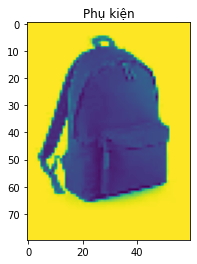

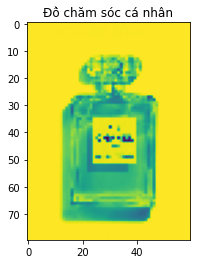

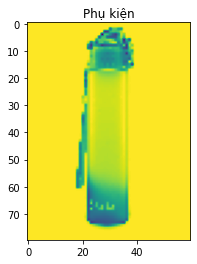

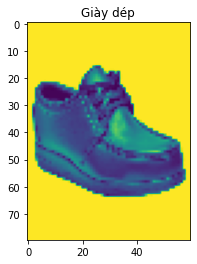

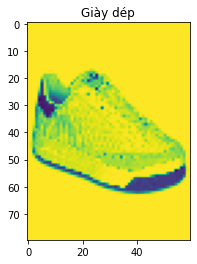

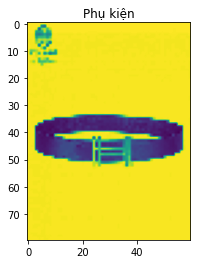

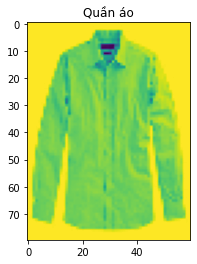

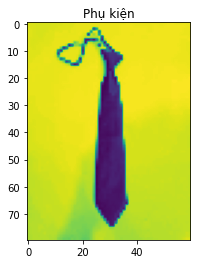

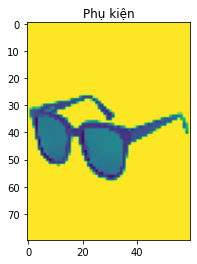

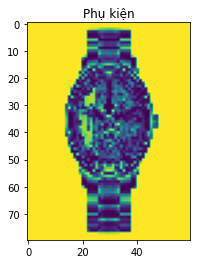

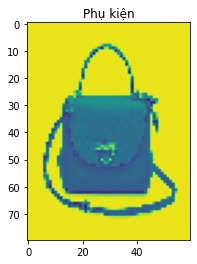

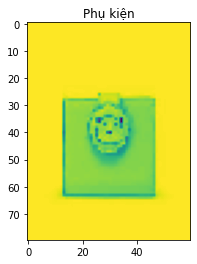

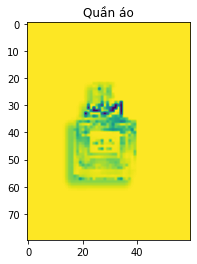

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 
from pathlib import Path
import warnings
from skimage.feature import hog
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import joblib

test_image = []
categories = ['Quần áo', 'Phụ kiện', 'Giày dép', 'Đồ chăm sóc cá nhân', 'Khác']
filename = "Completed_model.joblib"
model = joblib.load(filename)

for img in glob.glob("testImage/*.jpg"):
    im = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    test_image.append(im)



for image in test_image:
    hog_features_test = []

    resizeImg = cv2.resize(image, (60, 80),interpolation =cv2.INTER_LINEAR)

    blur = cv2.GaussianBlur(resizeImg,(5,5),0)

    fd,hog_image = hog(blur, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,transform_sqrt=True, block_norm="L2")

    hog_features_test.append(fd)
    hog_features_test = np.array(hog_features_test)
    y_pred_user = model.predict(hog_features_test)

    plt.imshow(resizeImg)
    plt.title(categories[int(y_pred_user)])
    plt.show()


The hog() function takes 6 parameters as input:

### image: The target image you want to apply HOG feature extraction.
### orientations: Number of bins in the histogram we want to create, the original research paper used 9 bins so we will pass 9 as orientations.
### pixels_per_cell: Determines the size of the cell, as we mentioned earlier, it is 8x8.
### cells_per_block: Number of cells per block, will be 2x2 as mentioned previously.
### visualize: A boolean whether to return the image of the HOG, we set it to True so we can show the image.
### multichannel: We set it to True to tell the function that the last dimension is considered as a color channel, instead of spatial.

Kích thước hog features:  (18144,)


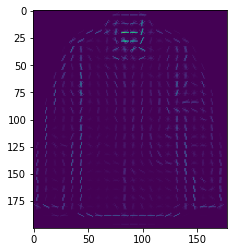

In [14]:
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2
image = cv2.imread('sample.jpg',cv2.IMREAD_GRAYSCALE)

blur = cv2.GaussianBlur(image,(5,5),0)

fd, hog_image = hog(blur, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, block_norm= 'L2')

print('Kích thước hog features: ', fd.shape)
plt.imshow(hog_image)
plt.show()




In [1]:

from sklearn import tree
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
import cv2 as cv
from pathlib import Path
import warnings
from skimage.feature import hog
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import joblib
from sklearn import datasets, svm, metrics
from sklearn import metrics

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

#define paths and read data
style_file = './myntradataset/styles.csv'
image_folder =  './myntradataset/images/'
styles = pd.read_csv(Path(style_file),error_bad_lines=False)


#Load image to list all_images
all_images = []


def load_image(ids,path=image_folder):
    img = cv.imread(image_folder+ids+'.jpg',cv.IMREAD_GRAYSCALE) #load at gray scale
    return img,ids

for ids in tqdm(list(styles.id)[:44000]):
    img,ids = load_image(str(ids))
    if img is not None:
        all_images.append([img,int(ids)])

def resize_image(img,ids):
    return cv.resize(img, (60, 80),interpolation =cv.INTER_LINEAR)
    
all_images_resized = [[resize_image(x,y),y] for x,y in all_images]


#Check distribution of the classes¶
df_labels = pd.DataFrame(all_images_resized,columns=['image','id'])

target = 'masterCategory'
categories = ['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items']
df_train = styles[styles[target].isin(categories)][['id',target]]

df_labels = pd.merge(df_labels,df_train,how='left',on=['id'])
df_labels = df_labels.fillna('Others')
df_labels['class'] = pd.factorize(df_labels[target])[0]



#mapper for targets and labels
mapper = df_labels[['class',target]].drop_duplicates()

#Feature Extraction using HOG
train_images = np.stack(df_labels.image.values,axis=0)
ppcr = 8
ppcc = 8
hog_images = []
hog_features = []
for image in tqdm(train_images):
    blur = cv.GaussianBlur(image,(5,5),0)
    fd,hog_image = hog(blur, orientations=9, pixels_per_cell=(ppcr,ppcc),cells_per_block=(2,2),visualize=True,transform_sqrt=True, block_norm="L2")
    hog_images.append(hog_image)
    hog_features.append(fd)

hog_features = np.array(hog_features)


    
train_features, test_features ,train_label, test_label = train_test_split(
    hog_features,df_labels['class'],test_size=0.2,stratify=df_labels['class'])



#k-NN algorithm 
test_accuracy1 = []


model1 = KNeighborsClassifier(algorithm='auto',n_neighbors=1)
model1.fit(train_features, train_label)

y_pred1 = model1.predict(test_features)
test_accuracy1 = model1.score(test_features,test_label)



model2 = tree.DecisionTreeClassifier()
model2 = model2.fit(train_features, train_label)
 
y_pred2 = model2.predict(test_features)
test_accuracy2 = model2.score(test_features,test_label)

print("KNN Algorithm: ")
print("Accuracy: ",test_accuracy1*100)
print("Decision Tree: ")
print("Accuracy: ",test_accuracy2*100)
print("----------------")
print ("Print results for 20 test data points:")
print ("KNN - Predicted labels: ", y_pred1[-20:])
print ("Decision Tree - Predicted labels: ", y_pred2[-20:])
print ("Ground truth    : ", test_label[-20:].values)


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

KNN Algorithm: 
Accuracy:  98.65893851574043
Decision Tree: 
Accuracy:  93.57881577451982
----------------
Print results for 20 test data points:
KNN - Predicted labels:  [2 1 1 0 0 0 0 0 0 1 1 2 0 2 0 0 2 1 1 0]
Decision Tree - Predicted labels:  [2 1 1 0 0 0 0 0 0 1 1 2 0 2 0 0 2 1 1 0]
Ground truth    :  [2 1 5 0 0 0 0 0 0 1 1 2 0 2 0 0 2 1 1 0]


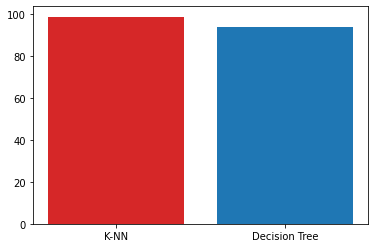

In [1]:
import matplotlib.pyplot as plt




fruits = ['K-NN', 'Decision Tree']
counts = [98.7, 93.6]
fig, ax = plt.subplots()
bar_labels = ['red', 'blue']
bar_colors = ['tab:red', 'tab:blue']
ax.bar(fruits, counts, label=bar_labels, color=bar_colors)


plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 177.5, 199.5, -0.5)

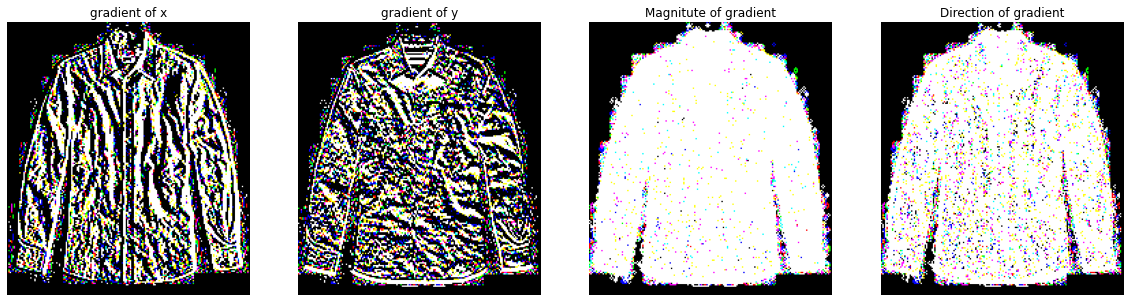

In [7]:
# Calculate gradient gx, gy
import matplotlib.pyplot as plt
import cv2
import numpy as np
img = plt.imread('sample.jpg', cv2.COLOR_BGR2GRAY)
xkernel = np.array([[-1, 0, 1]])
ykernel = np.array([[-1], [0], [1]])
dx = cv2.filter2D(img, cv2.CV_32F, xkernel)
dy = cv2.filter2D(img, cv2.CV_32F, ykernel)



g, theta = cv2.cartToPolar(dx, dy, angleInDegrees=True) 

w = 20
h = 10

plt.figure(figsize=(w, h))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(dx)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(dy)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(g)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(theta)
plt.axis('off')

In [30]:
from skimage.feature import hog
import cv2

img = cv2.imread('./testImage/46239.jpg')
print('Kích thước ảnh gốc: ', img.shape)

# 1. Khai báo các tham số
cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# 2. Tính toán các tham số truyền vào HOGDescriptor
# winSize: Kích thước của bức ảnh được crop để chia hết cho cell size.
winSize = (img.shape[1] // cell_size[1] * cell_size[1], img.shape[0] // cell_size[0] * cell_size[0])
# blockSize: Kích thước của 1 block
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
# blockStride: Số bước di chuyển của block khi thực hiện chuẩn hóa histogram bước 3
blockStride = (cell_size[1], cell_size[0])
print('Kích thước bức ảnh crop theo winSize (pixel): ', winSize)
print('Kích thước của 1 block (pixel): ', blockSize)
print('Kích thước của block stride (pixel): ', blockStride)

# 3. Compute HOG descriptor
hog = cv2.HOGDescriptor(_winSize=winSize,
                        _blockSize=blockSize,
                        _blockStride=blockStride,
                        _cellSize=cell_size,
                        _nbins=nbins)

# Kích thước của lưới ô vuông.
n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
print('Kích thước lưới ô vuông (ô vuông): ', n_cells)

# Reshape hog feature
hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  

print('Kích thước hog feature (h, w, block_size_h, block_size_w, nbins): ', hog_feats.shape)

Kích thước ảnh gốc:  (80, 60, 3)
Kích thước bức ảnh crop theo winSize (pixel):  (56, 80)
Kích thước của 1 block (pixel):  (16, 16)
Kích thước của block stride (pixel):  (8, 8)
Kích thước lưới ô vuông (ô vuông):  (10, 7)
Kích thước hog feature (h, w, block_size_h, block_size_w, nbins):  (9, 6, 2, 2, 9)


In [25]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
from skimage.feature import hog
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm

import joblib
from sklearn import datasets, svm, metrics
from sklearn import metrics

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

#define paths and read data
style_file = './myntradataset/styles.csv'
image_folder =  './myntradataset/images/'
styles = pd.read_csv(Path(style_file),error_bad_lines=False)


#Load image to list all_images
all_images = []


def load_image(ids,path=image_folder):
    img = cv.imread(image_folder+ids+'.jpg',cv.IMREAD_GRAYSCALE) #load at gray scale
    return img,ids

for ids in tqdm(list(styles.id)[:1000]):
    img,ids = load_image(str(ids))
    if img is not None:
        all_images.append([img,int(ids)])

def resize_image(img,ids):
    return cv.resize(img, (60, 80),interpolation =cv.INTER_LINEAR)
    
all_images_resized = [[resize_image(x,y),y] for x,y in all_images]


#Check distribution of the classes¶
df_labels = pd.DataFrame(all_images_resized,columns=['image','id'])

target = 'masterCategory'
categories = ['Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items']
df_train = styles[styles[target].isin(categories)][['id',target]]

df_labels = pd.merge(df_labels,df_train,how='left',on=['id'])
df_labels = df_labels.fillna('Others')
df_labels['class'] = pd.factorize(df_labels[target])[0]


print("Data Shape: ", str(df_labels.shape))
print(df_labels[target].value_counts())

#mapper for targets and labels
mapper = df_labels[['class',target]].drop_duplicates()


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

Data Shape:  (1000, 4)
Apparel          454
Accessories      265
Footwear         220
Personal Care     58
Free Items         3
Name: masterCategory, dtype: int64
